In [ ]:
!pip install keras_core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 5.2 MB/s eta 0:00:00


**IMPORTING LIBRARIES**

In [ ]:
# LIBRARIES

# Global
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import regex as re

# Function to plot WordCloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Tensorflow/Keras
import tensorflow as tf
import keras_core as keras
from keras import layers, Sequential
from keras.layers import TextVectorization
from keras.callbacks import (ModelCheckpoint,
                             EarlyStopping,
                             ReduceLROnPlateau,
                             CSVLogger,
                             LearningRateScheduler)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, precision_recall_curve,
                             roc_curve, auc)

os.environ["KERAS_BACKEND"] = "tensorflow"  # or "tensorflow" or "torch"

# Set Seed for Reproducibility
keras.utils.set_random_seed(42)

# Use mixed precision to speed up all training.
keras.mixed_precision.set_global_policy("mixed_float16")

# Check Versions
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

Using TensorFlow backend
TensorFlow: 2.15.0
Keras: 0.1.7


**CFG FOR COMPRESS FUNCTION**

In [ ]:
def compress(df, verbose=True):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum() / (1024 ** 2)
    if verbose:
        print("Old dataframe size:", round(input_size, 2), 'MB')

    in_size = df.memory_usage(index=True).sum()
    dtype_before = df.dtypes.copy()  # Copy of original data types

    for col in df.select_dtypes(include=['float64', 'int64']):
        col_type = df[col].dtype
        col_min, col_max = df[col].min(), df[col].max()

        if col_type == 'int64':
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        elif col_type == 'float64':
            ## float16 warns of overflow
            # if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            #     df[col] = df[col].astype(np.float16)
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            elif col_min > np.finfo(np.float64).min and col_max < np.finfo(np.float64).max:
                df[col] = df[col].astype(np.float64)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    if verbose:
        print("Optimized size by {}%".format(round(ratio, 2)))
        print("New DataFrame size:", round(out_size / (1024 ** 2), 2), "MB")

    # Filter only numerical columns for comparison
    numeric_columns = df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])
    dtype_after = numeric_columns.dtypes.copy()  # Copy of data types after compression

    # Create a comparison DataFrame
    comparison_df = pd.DataFrame({'Before': dtype_before[numeric_columns.columns], 'After': dtype_after})
    comparison_df['Size Reduction'] = ratio

    return df, comparison_df

**WORD CLOUD**

In [ ]:
# Generate WordCloud

def generate_wordcloud_subplot(df, label_value, subplot_position, max_words=1000, width=800, height=400, top_n = 10):



    # Select the text subset for the specified label value
    text_subset = df[df.generated == label_value].text

    # Define stopwords to be excluded
    stopwords = set(STOPWORDS)

    # Create a WordCloud object with specified parameters
    wc = WordCloud(max_words=max_words, width=width, height=height, stopwords=stopwords)

    # Generate the word cloud from the selected text subset
    wc.generate(" ".join(text_subset))

    # Create a subplot and display the word cloud
    plt.subplot(subplot_position)
    plt.imshow(wc, interpolation='bilinear')

    # Set the title for the word cloud plot
    title = f'WordCloud for Label {label_value} ({("Student" if label_value == 0 else "AI")})'
    plt.title(title)

    # Count occurrences of words in the text subset
    words_count = Counter(" ".join(text_subset).split())
    top_words = words_count.most_common(top_n)
    bottom_words = words_count.most_common()[:-top_n-1:-1]  # Extract least common words

    # Print the most common words
    print(f"Top {top_n} words for Label {label_value}:")
    for idx, (word, count) in enumerate(top_words, start=1):
        print(f"{idx}. {word}: {count} times")
    print("------------------------------")

    # Print the least common words
    print(f"Least {top_n} words for Label {label_value}:")
    for idx, (word, count) in enumerate(bottom_words, start=1):
        print(f"{idx}. {word}: {count} times")
    print("------------------------------")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Essays Train Dataset

df_train_essays = pd.read_csv('/content/drive/My Drive/train_essays.csv')

print(df_train_essays.info())
df_train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         500 non-null    object
 1   prompt_id  500 non-null    int64 
 2   text       500 non-null    object
 3   generated  500 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.8+ KB
None


,id,prompt_id,text,generated
0,d429f032,0,Advantages of Limiting Car Usage \n\nLimiting ...,1
1,1ce279be,0,Advantages of Limiting Car Usage\n\nLimiting c...,1
2,c9595213,0,Limiting car usage has numerous advantages tha...,1
3,f2266d87,0,The passages provided discuss the advantages o...,1
4,eeace4bd,0,Title: The Advantages of Limiting Car Usage\n\...,1


In [ ]:
# Compression

# Compress dataframe
df_train_essays, comparison_df = compress(df_train_essays, verbose=True)

# Check compression
comparison_df

Old dataframe size: 0.02 MB
Optimized size by 43.0%
New DataFrame size: 0.01 MB


,Before,After,Size Reduction
prompt_id,int64,int8,43.0
generated,int64,int8,43.0


In [ ]:
# Checking the first essay text

df_train_essays.text[0]

'Advantages of Limiting Car Usage \n\nLimiting car usage can have a number of advantages for individuals and the community as a whole. The passage set provides evidence of this trend happening in different parts of the world, including Germany, France, and Colombia. In these places, efforts have been made to reduce the dependence on cars and promote alternative modes of transportation. Limiting car usage can lead to a cleaner environment, healthier individuals, and better community planning.\n\nOne of the main advantages of limiting car usage is the reduction of greenhouse gas emissions and air pollution. According to the passages, passenger cars are responsible for a significant percentage of greenhouse gas emissions in Europe and some car-intensive areas in the United States. By reducing the number of cars on the road, we can significantly decrease the amount of pollution being released into the environment. This is particularly important in densely populated areas like cities, where

In [ ]:
# Essays Test Dataset

df_test_essays = pd.read_csv('/content/drive/My Drive/test_essays.csv')

print(df_test_essays.info())
df_test_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         29 non-null     object
 1   prompt_id  29 non-null     object
 2   text       30 non-null     object
dtypes: object(3)
memory usage: 848.0+ bytes
None


,id,prompt_id,text
0,weccl_45,WECCL-17,"Dear Principal,\n\nIn the policy containing th..."
1,weccl_46,WECCL-18,Technology in society is constantly innovating...
2,weccl_47,WECCL-19,"Hey there! So, you're asking me to write an e..."
3,weccl_48,WECCL-20,"University education is a contentious issue, w..."
4,weccl_49,WECCL-21,People ask for advice from others all the time...


In [ ]:
# Compression

# Compress dataframe
df_test_essays, comparison_df = compress(df_test_essays, verbose=True)

# Check compression
comparison_df

Old dataframe size: 0.0 MB
Optimized size by 0.0%
New DataFrame size: 0.0 MB


,Before,After,Size Reduction


In [ ]:
# Checking the first essay text

df_test_essays.text[0]

"Dear Principal,\n\nIn the policy containing that students should not have a grade C average to participate in school sport programs that they enjoy or any other school related activities should be changed to having a grade B average.\n\nIf you allow them to be apart of something they enjoy and care about then they shouldn't have a grade C average. Students that do what they enjoy and care about such as sports and or school activities should care enough to make the good grades for those activities. Being in those activities and sports is a privilege. Not something that is just given to you. They should care enough to make the required grades if they really wanted to play that sport or activity. Let the student know that they should have better grades in order to play the sport. It's up to them to get that grades to play the game or be in the activity. If they want to continue playing the sport or activity then they should get the grades required such as a grade B average. By telling th

In [ ]:
# Checking length of the essays

df_test_essays["text"].apply(lambda x : len(x))

0     1571
1     3392
2     1350
3     1909
4      763
5      469
6      973
7     1047
8     1238
9     1657
10    1911
11    1992
12    1158
13     869
14     658
15    1050
16    1398
17    1936
18    1769
19    2533
20    2061
21    1008
22     913
23     928
24    1142
25    1764
26    2143
27    2070
28    2200
29     270
Name: text, dtype: int64

In [ ]:
# Prompts Dataset

df_train_prompts = pd.read_csv("/content/train_prompts.csv")
print(df_train_prompts.info())

df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     201 non-null    int64 
 1   prompt_name   201 non-null    object
 2   instructions  201 non-null    object
 3   source_text   201 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...
2,2,text-babbage-001,Some people think the university education is ...,There are a variety of opinions on the purpose...
3,3,text-curie-001,Some people think the university education is ...,The university education is not only for prepa...
4,4,text-curie-001,Some people think the university education is ...,I believe that the university education is mor...


In [ ]:
# Compression

# Compress dataframe
df_train_prompts, comparison_df = compress(df_train_prompts, verbose=True)

# Check compression
comparison_df

Old dataframe size: 0.01 MB
Optimized size by 18.0%
New DataFrame size: 0.01 MB


,Before,After,Size Reduction
prompt_id,int64,int16,18.0


In [ ]:
# Checking the first instruction given to students

df_train_prompts.instructions[0]

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [ ]:
# Checking the first text

df_train_prompts.source_text[0]

'# In German Suburb, Life Goes On Without Cars by Elisabeth Rosenthal\n\n1 VAUBAN, Germany—Residents of this upscale community are suburban pioneers, going where few soccer moms or commuting executives have ever gone before: they have given up their cars.\n\n2 Street parking, driveways and home garages are generally forbidden in this experimental new district on the outskirts of Freiburg, near the French and Swiss borders. Vauban’s streets are completely “car-free”—except the main thoroughfare, where the tram to downtown Freiburg runs, and a few streets on one edge of the community. Car ownership is allowed, but there are only two places to park—large garages at the edge of the development, where a car-owner buys a space, for $40,000, along with a home.\n\n3 As a result, 70 percent of Vauban’s families do not own cars, and 57 percent sold a car to move here. “When I had a car I was always tense. I’m much happier this way,” said Heidrun Walter, a media trainer and mother of two, as she 

In [ ]:
print(df_train_essays['prompt_id'].value_counts())

0    250
1    250
Name: prompt_id, dtype: int64


<ipython-input-21-9392581ac528>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_train_essays, x="prompt_id", palette="viridis")
<ipython-input-21-9392581ac528>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Student", "AI"])


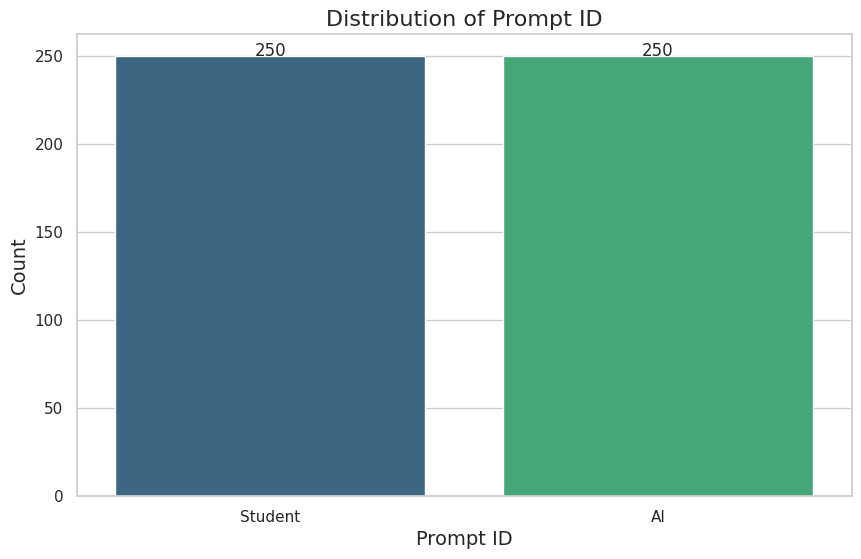

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Figure
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the count plot
ax = sns.countplot(data=df_train_essays, x="prompt_id", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

# Obtaining and setting the count values
abs_values = df_train_essays['prompt_id'].value_counts().values

# Adding labels manually
for i, v in enumerate(abs_values):
    ax.text(i, v + 0.1, str(v), ha='center', fontsize=12)

# Set title and labels with increased font sizes
ax.set_title("Distribution of Prompt ID", fontsize=16)
ax.set_xlabel("Prompt ID", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()


<ipython-input-25-521c012b04dc>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_train_essays, x="generated", palette="viridis")
<ipython-input-25-521c012b04dc>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Student", "AI"])


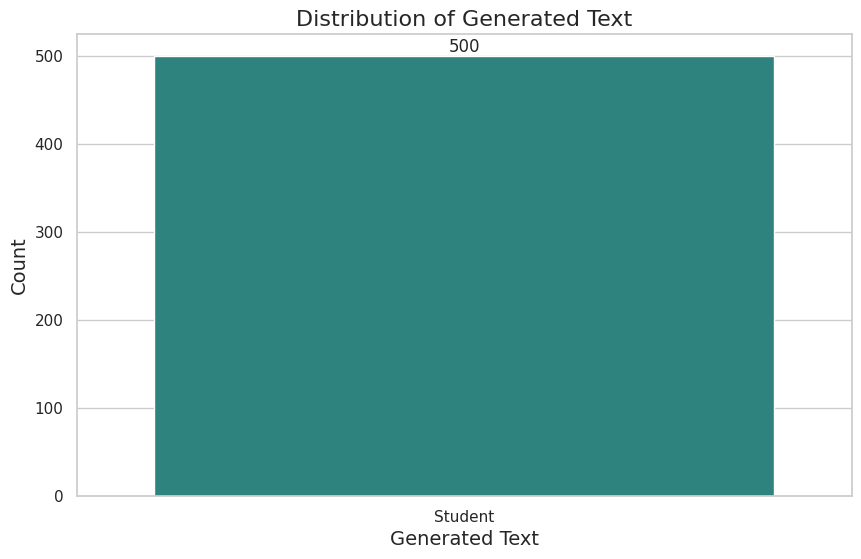

In [ ]:
# Distribution of Generated Text

# Set Figure
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the count plot
ax = sns.countplot(data=df_train_essays, x="generated", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

# Obtaining and setting the count values
abs_values = df_train_essays['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=12)

# Set title and labels with increased font sizes
ax.set_title("Distribution of Generated Text", fontsize=16)
ax.set_xlabel("Generated Text", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

In [ ]:
#Import external dataset

ext1 = pd.read_csv('/content/drive/My Drive/train_v2_drcat_02.csv')

In [ ]:
ext1.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [ ]:
# Check duplicates

# Get the number of rows with duplicates
duplicates = ext1.duplicated().sum()

# Print the number of rows before and after
print(f"Number of rows with duplicates: {duplicates}")

Number of rows with duplicates: 0


In [ ]:
# Compression

# Compress dataframe
ext1, comparison_df = compress(ext1, verbose=True)

# Check compression
comparison_df

Old dataframe size: 1.41 MB
Optimized size by 21.0%
New DataFrame size: 1.11 MB


,Before,After,Size Reduction
label,int64,int8,21.0


The dataset contains several columns that will not be necessary for our specific problem. Therefore we will remove them and rename the `label` column to `generated`.

In [ ]:
# Drop Columns

ext1.drop(["RDizzl3_seven", "prompt_name", "source", "prompt_name"], inplace=True, axis=1)

ext1.head()

,text,label
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [ ]:
# Rename label column

ext1.rename(columns = {"label":"generated"}, inplace=True)

ext1.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


<ipython-input-32-db9bc5e82e50>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=ext1, x="generated", palette="viridis")
<ipython-input-32-db9bc5e82e50>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Student", "AI"])


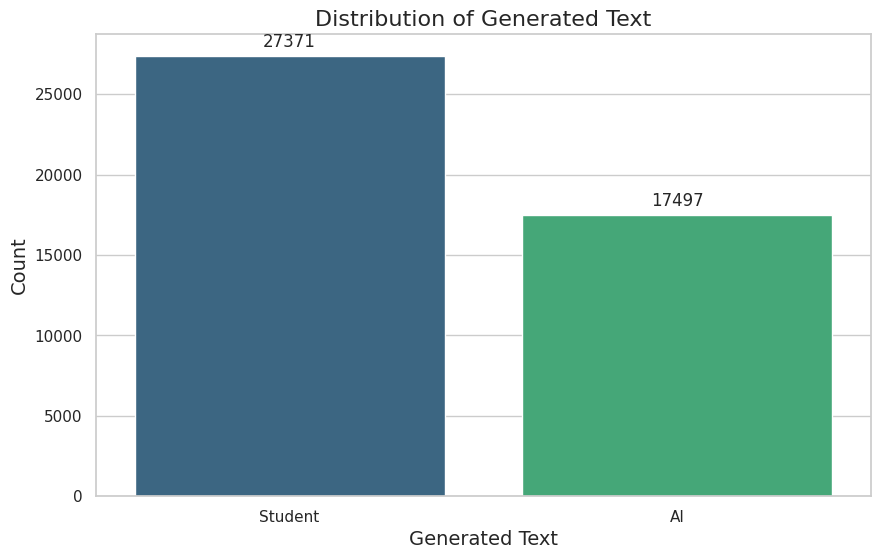

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Figure
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the count plot
ax = sns.countplot(data=ext1, x="generated", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

# Obtaining and setting the count values
abs_values = ext1['generated'].value_counts().values

# Add labels to the bars
for i, p in enumerate(ax.patches):
    ax.annotate(abs_values[i], (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Set title and labels with increased font sizes
ax.set_title("Distribution of Generated Text", fontsize=16)
ax.set_xlabel("Generated Text", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()


Top 10 words for Label 1:
1. to: 210391 times
2. and: 207318 times
3. the: 205134 times
4. a: 142997 times
5. of: 132836 times
6. in: 85734 times
7. can: 81521 times
8. that: 77453 times
9. is: 74384 times
10. for: 58432 times
------------------------------
Least 10 words for Label 1:
1. administer: 1 times
2. ratified.: 1 times
3. 55.7%,: 1 times
4. donors.: 1 times
5. Nebraska).: 1 times
6. (Maine: 1 times
7. Representatives).: 1 times
8. 3.8: 1 times
9. 578,000: 1 times
10. 49%: 1 times
------------------------------
Top 10 words for Label 0:
1. the: 488916 times
2. to: 410350 times
3. and: 268688 times
4. a: 268355 times
5. of: 219057 times
6. that: 176860 times
7. is: 168992 times
8. in: 158714 times
9. be: 130641 times
10. you: 127159 times
------------------------------
Least 10 words for Label 0:
1. States.According: 1 times
2. aboutinstead: 1 times
3. bumpertobumper: 1 times
4. 2005": 1 times
5. hybridelectric: 1 times
6. winnertakeitall: 1 times
7. world.Source: 1 times
8. pl

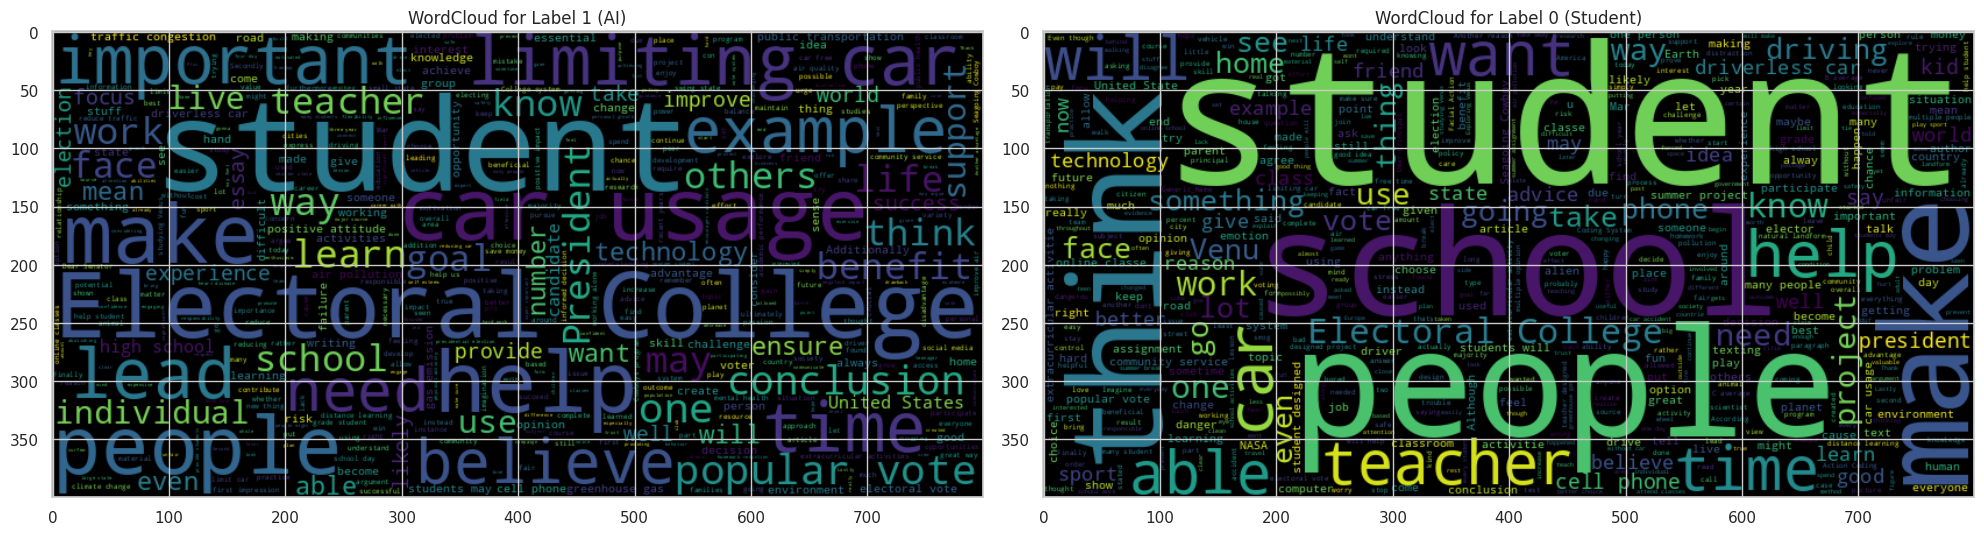

In [ ]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(ext1, label_value=1, subplot_position=121, top_n = 10)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(ext1, label_value=0, subplot_position=122, top_n = 10)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

**PREPROCESSING**

In [ ]:
# Clean Text

def clean_text(text):
    # Replace actual newline and carriage return characters with whitespace
    text = text.replace("\n", " ")
    text = text.replace("\r", " ")

    # Drop punctuation
    text = re.sub(r"\p{P}", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)

    # Remove leading and trailing whitespace
    text = text.strip()

    # Lower text
    text = text.lower()

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    return text

# Apply the clean_text function to the 'text' column in the DataFrame
ext1['text'] = ext1['text'].apply(clean_text)

# Change contractions
contractions = {
    r'\b(can\'t)\b': 'cannot',
    r'\b(don\'t)\b': 'do not',
    r'\b(won\'t)\b': 'will not',
}

# Iterate through contractions and apply replacements to the entire DataFrame column
for pattern, replacement in contractions.items():
    ext1['text'] = ext1['text'].apply(lambda x: re.sub(pattern, replacement, x, flags=re.IGNORECASE))


In [ ]:
# setting the stopwords list

stopword_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
len(stopword_list)

179

In [ ]:
# Remove Stopwords

def remove_custom_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stopword_list]
    return ' '.join(filtered_words)

# Apply the function to the 'text' column
ext1['text'] = ext1['text'].apply(remove_custom_stopwords)

In [ ]:
# Check duplicates

# Get the number of rows with duplicates
duplicates = ext1.duplicated().sum()

# Print the number of rows before and after
print(f"Number of rows with duplicates: {duplicates}")

Number of rows with duplicates: 16


In [ ]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(ext1, label_value=1, subplot_position=121, top_n = 10)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(ext1, label_value=0, subplot_position=122, top_n = 10)


plt.tight_layout()  # Adjust spacing between subplots

plt.show()

Top 10 words for Label 1:
1. students: 40987 times
2. like: 25589 times
3. also: 23740 times
4. people: 23396 times
5. help: 21912 times
6. car: 21197 times
7. school: 19871 times
8. may: 19863 times
9. electoral: 18685 times
10. time: 18407 times
------------------------------
Least 10 words for Label 1:
1. unitary: 1 times
2. uncompetitive: 1 times
3. voiceless: 1 times
4. overrepresent: 1 times
5. tiered: 1 times
6. delegitimize: 1 times
7. provisional: 1 times
8. disgrace: 1 times
9. nationalization: 1 times
10. middleman: 1 times
------------------------------


**MODELING**

In [ ]:
# Copy the final_df as df_model

df_model = ext1.copy()

df_model.generated.value_counts()

0    27371
1    17497
Name: generated, dtype: int64

In [ ]:
# Create a shuffled df for a good labels distribution

# Set a random seed for reproducibility
random_seed = 42

print("Before shuffling:", df_model.shape)

# Shuffle the DataFrame with the specified random seed
shuffled_df = df_model.sample(frac=1, random_state=random_seed)

print("After shuffling:", df_model.shape)

Before shuffling: (44868, 2)
After shuffling: (44868, 2)


In [ ]:
# Create a train/val/test split
X = shuffled_df["text"]
y = shuffled_df["generated"]


# Split the data into train, validation, and test sets (80% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Display the shapes of the train, validation, and test sets
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31407,)
X_validation shape: (6730,)
X_test shape: (6731,)
y_train shape: (31407,)
y_validation shape: (6730,)
y_test shape: (6731,)


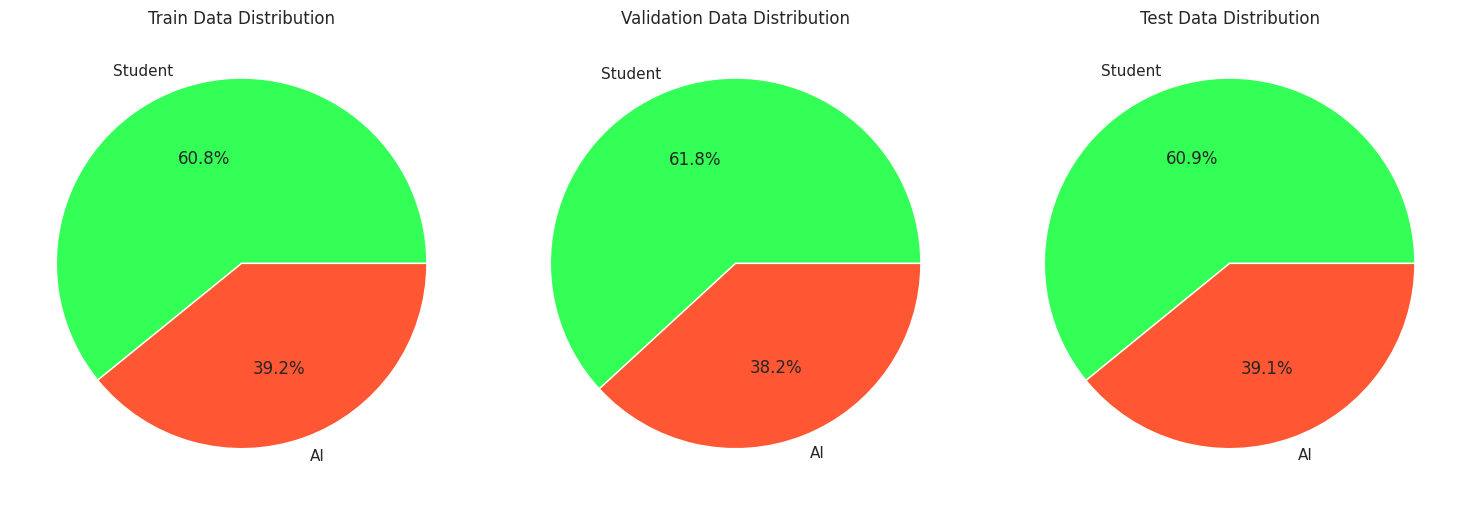

In [ ]:
# Get label counts for train, validation, and test data
train_label_counts = y_train.value_counts()
val_label_counts = y_val.value_counts()
test_label_counts = y_test.value_counts()

# Define custom labels for visualization
custom_labels = {0: 'Student', 1: 'AI'}

# Replace labels for visualization purposes
train_labels_visual = train_label_counts.rename(custom_labels)
val_labels_visual = val_label_counts.rename(custom_labels)
test_labels_visual = test_label_counts.rename(custom_labels)

# Define custom colors for each label
label_colors = {'Student': '#33FF57', 'AI': '#FF5733'}

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Train data distribution
wedges, texts, autotexts = axes[0].pie(train_labels_visual, labels=train_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in train_labels_visual.index])
axes[0].set_title('Train Data Distribution')

# Subplot 2: Validation data distribution
wedges, texts, autotexts = axes[1].pie(val_labels_visual, labels=val_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in val_labels_visual.index])
axes[1].set_title('Validation Data Distribution')

# Subplot 3: Test data distribution
wedges, texts, autotexts = axes[2].pie(test_labels_visual, labels=test_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in test_labels_visual.index])
axes[2].set_title('Test Data Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# Check the max vocaulary size

text_vectorizer = TextVectorization(split="whitespace",
                                    output_mode="int")

# Fit the text vectorizer
text_vectorizer.adapt(X)

# Get the number of unique tokens in the vocabulary
vocab_size = len(text_vectorizer.get_vocabulary())

# Print the vocabulary size
print("Vocabulary size:", vocab_size)

Vocabulary size: 76851


In [ ]:
# Setup text vectorization with custom variables

# Set the maximum vocabulary size
# max_vocab_size = 10000
max_vocab_size = vocab_size

# Calculate the maximum sequence length based on the average number of tokens in training data
average_tokens_per_sequence = round(sum([len(text.split()) for text in X_train]) / len(X_train))

# Create and configure the TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
#     ngrams=(3,5),
    output_mode="int",
    output_sequence_length=average_tokens_per_sequence,
    pad_to_max_tokens=True
)

# Adapt the TextVectorization layer to the training text
if len(X_train) > 0:
    text_vectorizer.adapt(X_train)
else:
    print("Warning: X_train is empty, adaptation skipped.")

In [ ]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_size,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=average_tokens_per_sequence)

In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

keras_model = tf.keras.Model(inputs, outputs)

# Compile model
keras_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Get a summary of the model
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 195)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 195, 128)          9836928   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9837057 (37.53 MB)
Trainable params: 9837057 (3

In [ ]:
# Fit the model

callbacks = [ModelCheckpoint(filepath='keras_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=7, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=5, monitor='val_loss'),
             CSVLogger('keras_training_log.csv')]


keras_model_history = keras_model.fit(X_train,
                                      y_train,
                                      epochs=100,
                                      validation_data=(X_val, y_val),
                                      callbacks=callbacks,
                                     # batch_size=32
                                     )

Epoch 1/100
982/982 [==============================] - 243s 246ms/step - loss: 0.1973 - accuracy: 0.9343 - val_loss: 0.0562 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 2/100
982/982 [==============================] - 240s 244ms/step - loss: 0.0369 - accuracy: 0.9914 - val_loss: 0.0327 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 3/100
982/982 [==============================] - 242s 247ms/step - loss: 0.0208 - accuracy: 0.9948 - val_loss: 0.0247 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 4/100
982/982 [==============================] - 241s 246ms/step - loss: 0.0131 - accuracy: 0.9975 - val_loss: 0.0211 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 5/100
982/982 [==============================] - 242s 247ms/step - loss: 0.0086 - accuracy: 0.9982 - val_loss: 0.0194 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 6/100
982/982 [==============================] - 244s 249ms/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0192 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 7/100
982/982 [===================

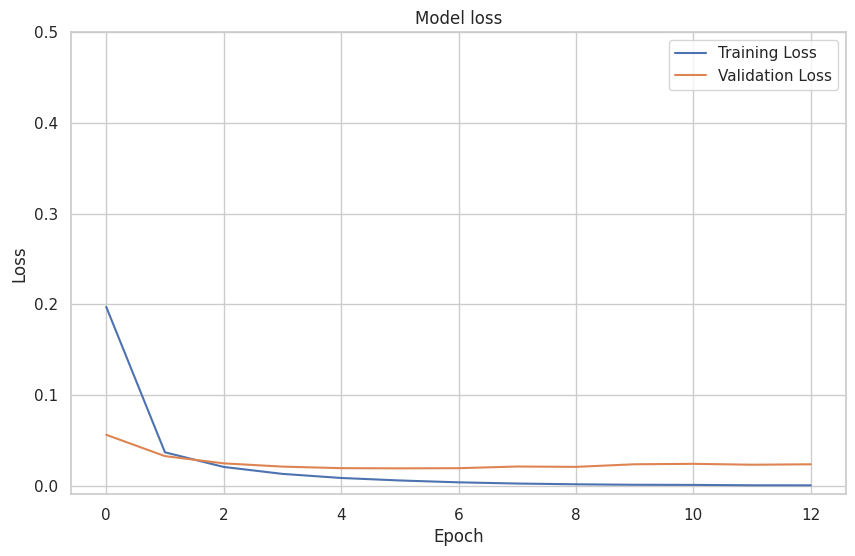

In [ ]:
# Plot learning curves

plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(keras_model_history.history['loss'], label='Training Loss')
plt.plot(keras_model_history.history['val_loss'], label='Validation Loss')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Set y-axis lower limit to 0.5
plt.ylim(top=0.5)

plt.show()


In [ ]:
# Make predictions on input data (X_test) in form of probabilities

keras_probabilities = keras_model.predict(X_test)
keras_probabilities[:5]

211/211 [==============================] - 1s 6ms/step


array([[4.3709363e-07],
       [9.9999142e-01],
       [1.8003668e-10],
       [8.6177973e-04],
       [1.0359638e-05]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
keras_prediction = tf.squeeze(tf.round(keras_probabilities))
keras_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 1., 1., 0., 0.], dtype=float32)>

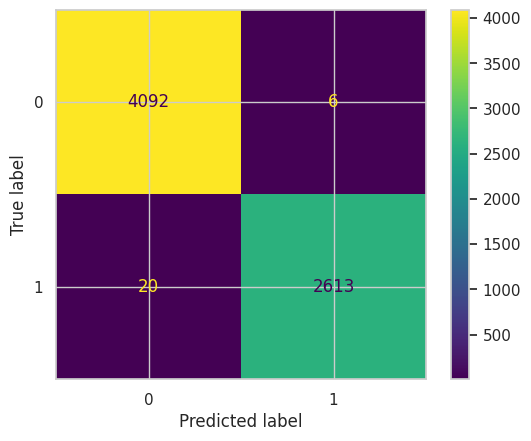

In [ ]:
# Plot confusion matrix

keras_cm = confusion_matrix(y_test, keras_prediction)
keras_cm_plot =ConfusionMatrixDisplay(confusion_matrix=keras_cm)

keras_cm_plot.plot()
plt.show()

In [ ]:
# Predictions from the model on the test set
y_pred = keras_model.predict(X_test)

# Converting probabilities to classes (assuming a threshold of 0.5)
y_pred_classes = (y_pred > 0.5).astype(int)

# Printing the classification report
print(classification_report(y_test, y_pred_classes))

211/211 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4098
           1       1.00      0.99      1.00      2633

    accuracy                           1.00      6731
   macro avg       1.00      1.00      1.00      6731
weighted avg       1.00      1.00      1.00      6731



### <font color='289C4E'>6.4.5. AUC - ROC Curve 📐<font><a class='anchor' id='roc'></a> [↑](#top)

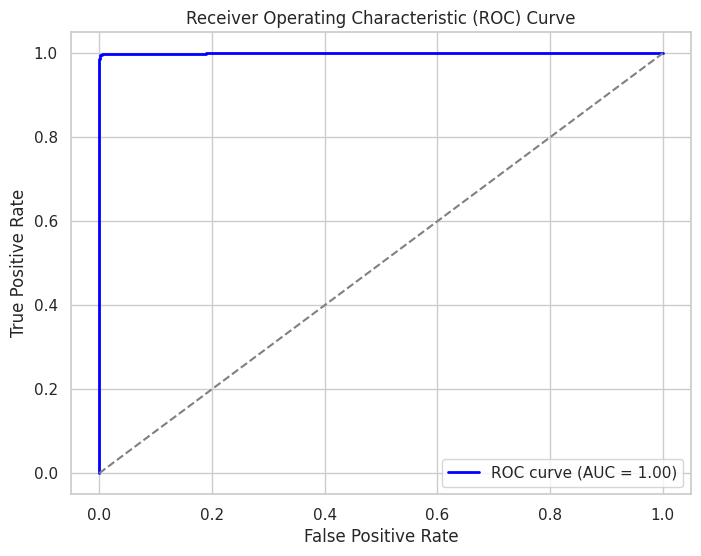

In [ ]:
# AUC -  ROC Curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set title and legend
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


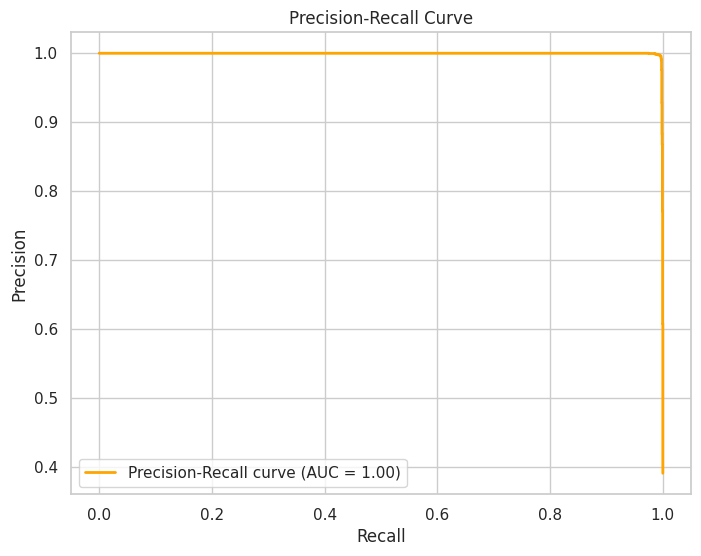

In [ ]:
# Precission-recall curve

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, keras_probabilities)

# Calculate AUC for precision-recall curve
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', lw=2, label='Precision-Recall curve (AUC = {:.2f})'.format(pr_auc))

# Set labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# Set title and legend
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.show()

# <font color='289C4E'>7. Submission 📩<font><a class='anchor' id='sub'></a> [↑](#top)

Let's submit our baseline model predictions!!

In [ ]:

test_prediction = keras_model.predict(df_test_essays["text"])
pred_answers = (test_prediction > 0.5).astype(int).squeeze()

# Check predictions
print("# Predictions\n")
for i in range(30):  # Adjust the range according to the number of samples you want to check
    text = df_test_essays.iloc[i]["text"]
    pred_answer = pred_answers[i]
    print(f"❓ Text {i+1}:\n{text}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-"*90, "\n")

1/1 [==============================] - 0s 45ms/step
# Predictions

❓ Text 1:
Dear Principal,

In the policy containing that students should not have a grade C average to participate in school sport programs that they enjoy or any other school related activities should be changed to having a grade B average.

If you allow them to be apart of something they enjoy and care about then they shouldn't have a grade C average. Students that do what they enjoy and care about such as sports and or school activities should care enough to make the good grades for those activities. Being in those activities and sports is a privilege. Not something that is just given to you. They should care enough to make the required grades if they really wanted to play that sport or activity. Let the student know that they should have better grades in order to play the sport. It's up to them to get that grades to play the game or be in the activity. If they want to continue playing the sport or activity then they

In [ ]:
# Create a DataFrame to store the submission
submission_df = df_test_essays[["id"]].copy()

# Add the formatted predictions to the submission DataFrame
submission_df["generated"] = test_prediction.squeeze()

# Save Submission
submission_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
submission_df.head()

,id,generated
0,weccl_45,0.000005
1,weccl_46,0.000324
2,weccl_47,0.006868
3,weccl_48,0.999713
4,weccl_49,0.001171
